# Bootstrap スペクトル推定チュートリアル（重なり補正つき）

このノートブックでは、スペクトログラム（時間×周波数）の各周波数ビンに対して **bootstrap による統計的に頑健な PSD 推定**を行い、
さらに Welch 法の一般原理に基づく **オーバーラップによる有効自由度の減少（分散拡大）**を窓関数の自己相関から補正します。

- `gwexpy.spectral.bootstrap_spectrogram` による推定（中心値 + CI ベース誤差）
- `window=None`（独立仮定）と `window='hann'`（重なり補正あり）の比較
- 既知の真の PSD モデルにフィットし、**reduced $\chi^2$ が 1 に近づく**ことをデモします


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.signal import get_window

from gwexpy.frequencyseries import FrequencySeries
from gwexpy.spectrogram import Spectrogram
from gwexpy.spectral import bootstrap_spectrogram, calculate_correlation_factor

plt.rcParams["figure.figsize"] = (10, 5)

## 1. 真の PSD モデル（合成データ生成用）

ここではシンプルに「パワー則 + 白色床（フラット）」を真の PSD とします。


FrequencySeries([5.03000000e-05, 4.78907198e-05, 4.56514739e-05,
                 ..., 1.34263056e-06, 1.33514311e-06,
                 1.32773603e-06]
                unit: 1 / Hz,
                f0: 10.0 Hz,
                df: 0.25 Hz,
                epoch: None,
                name: PSD True,
                channel: None)


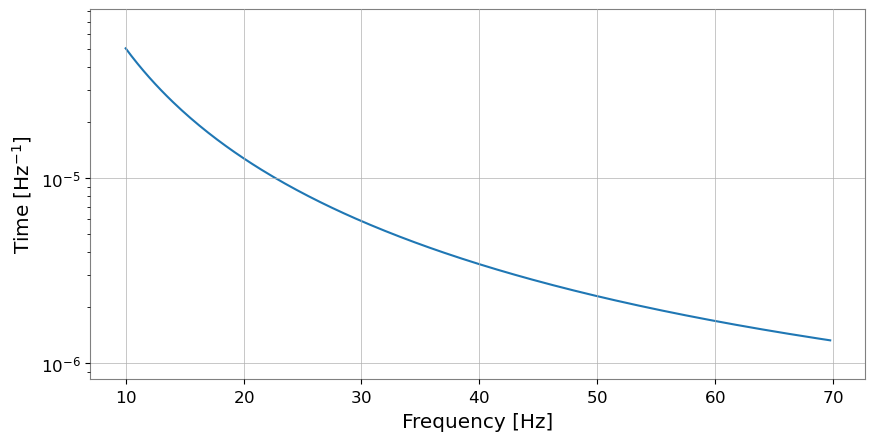

In [2]:
f_ref = 50.0  # Hz

def psd_model(f_hz, A, alpha, C):
    f_hz = np.asarray(f_hz, dtype=float)
    return A * (f_hz / f_ref) ** (-alpha) + C

# 真値
A_true = 2.0e-6
alpha_true = 2.0
C_true = 3.0e-7

n_freq = 240
df = 0.25 * u.Hz
f0 = 10.0 * u.Hz
freqs = (f0 + df * np.arange(n_freq)).to_value(u.Hz)
psd_true = FrequencySeries(psd_model(freqs, A_true, alpha_true, C_true),
                           frequencies=freqs,
                           name="PSD True", unit="1/Hz")
print(psd_true)
psd_true.plot();

## 2. 「重なりで相関する」スペクトログラムの合成

Welch の重なりでは、隣接セグメントの PSD 推定値が相関します。
ここでは Hann 窓 + 75% overlap を例に、窓自己相関（ラグ1〜3）の二乗を目標自己相関として、
時間方向に相関を持つスペクトログラムを合成します。


r_lags (target autocorr for PSD estimates): [1.0, 0.434485239425495, 0.027777777777777776, 5.6425986243099174e-05]
spectrogram shape: (128, 240)
Spectrogram([[4.85015708e-05, 4.18755908e-05, 5.57596519e-05,
              ..., 8.37011695e-07, 3.87188267e-07,
              7.38413399e-07],
             [7.09468258e-05, 3.79999177e-05, 6.66356588e-05,
              ..., 9.52546431e-07, 2.01254514e-07,
              1.18344992e-06],
             [6.78663803e-05, 7.82490161e-05, 4.19374603e-05,
              ..., 1.57340222e-06, 7.23007312e-07,
              1.90629062e-06],
             ...,
             [3.72827729e-05, 7.16060419e-05, 2.84904115e-05,
              ..., 9.99829306e-07, 1.17924304e-06,
              1.67297708e-06],
             [2.44287348e-05, 8.62753270e-05, 1.61766108e-05,
              ..., 9.22234747e-07, 1.70958102e-06,
              1.18980720e-06],
             [1.64997356e-05, 5.50868055e-05, 5.74369425e-05,
              ..., 1.46731807e-06, 1.39733277e-06,
    

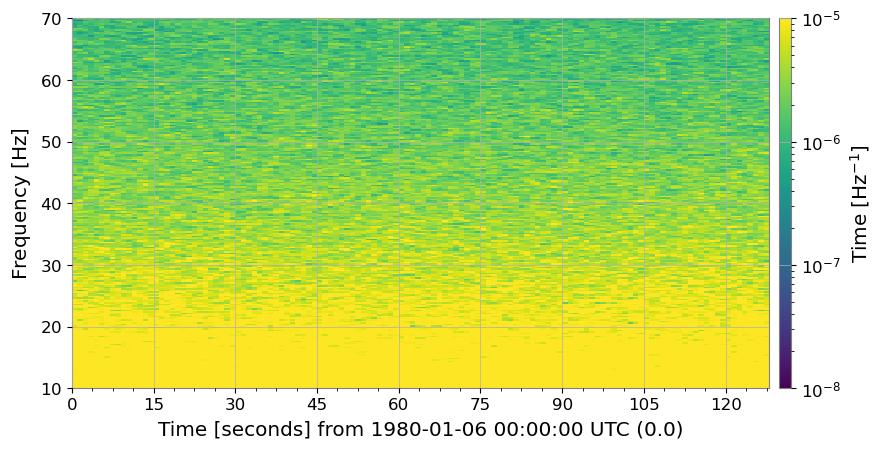

In [3]:
rng = np.random.default_rng(0)

# --- Welch 設定（例） ---
nperseg = 256
noverlap = 192  # 75% overlap
step = nperseg - noverlap
window = "hann"

# --- スペクトログラム軸 ---
n_time = 128

# dt と df はスペクトログラムのメタデータ（ここでは整合するよう設定）
# duration ≈ 1/df, stride = dt, overlap 比 = nperseg/step = 4
dt = 1.0 * u.s

# --- 窓自己相関（ラグ k*step）から PSD 推定値の相関を近似 ---
w = get_window(window, nperseg)
energy = np.sum(w**2)
max_lag = int(np.ceil(nperseg / step))
r = [1.0]
for k in range(1, max_lag):
    shift = k * step
    if shift >= nperseg:
        break
    rho = np.sum(w[:-shift] * w[shift:]) / energy
    r.append(float(rho**2))

print("r_lags (target autocorr for PSD estimates):", r)

# --- 時間方向の相関を持つガウス過程を Toeplitz 共分散で生成 ---
K = len(r) - 1
cov = np.zeros((n_time, n_time))
for lag in range(0, K + 1):
    val = r[lag]
    i = np.arange(n_time - lag)
    cov[i, i + lag] = val
    cov[i + lag, i] = val

jitter = 1e-12
for _ in range(6):
    try:
        L = np.linalg.cholesky(cov + jitter * np.eye(n_time))
        break
    except np.linalg.LinAlgError:
        jitter *= 10
else:
    raise RuntimeError("Failed to build Cholesky factor for covariance.")

# lognormal 揺らぎ（mean=1 に正規化）
sigma_ln = 0.40
eps = rng.normal(size=(n_time, n_freq))
x = L @ eps
x /= np.std(x, axis=0, keepdims=True)
g = np.exp(sigma_ln * x - 0.5 * sigma_ln**2)

spec_value = psd_true.value[None, :] * g

spec = Spectrogram(
    spec_value,
    dt=dt,
    f0=f0,
    df=df,
    unit="1/Hz",
    name="synthetic PSD",
)

print("spectrogram shape:", spec.value.shape)
print(spec)
spec.plot(vmin=1e-8, vmax=1e-5, yscale="linear");


## 3. Bootstrap 推定（重なり補正あり/なし）

- `window=None` は「独立」とみなす（補正なし）
- `window='hann'` は窓自己相関から補正係数を計算し、誤差を拡大


In [4]:
n_boot = 500
ci = 0.68  # 68% CI（正規近似なら ~1sigma 相当）

# 係数（理論）
factor = calculate_correlation_factor(window, nperseg, noverlap, n_time)
print(f"overlap correction factor (theory) = {factor:.3f}")

# 乱数の再現性のため同じ seed を使用（window によって中心値は変わらず、誤差のみ変わる）
np.random.seed(0)
psd_naive = bootstrap_spectrogram(
    spec,
    n_boot=n_boot,
    average="mean",
    ci=ci,
    window=None,
    nperseg=nperseg,
    noverlap=noverlap,
)

np.random.seed(0)
psd_corr = bootstrap_spectrogram(
    spec,
    n_boot=n_boot,
    average="mean",
    ci=ci,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
)

# 参考: Spectrogram 側のショートカット（同じこと）
np.random.seed(0)
psd_corr2 = spec.bootstrap_asd(
    n_boot=n_boot,
    average="mean",
    ci=ci,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
)

print("center equal (corr vs wrapper):", np.allclose(psd_corr.value, psd_corr2.value))
print("mean(error_ratio) ~", np.mean(psd_corr.error_low.value / psd_naive.error_low.value))


overlap correction factor (theory) = 1.385
center equal (corr vs wrapper): True
mean(error_ratio) ~ 1.3845502352711319


## 4. 真の PSD にフィットして reduced $\chi^2$ を比較

ここでは 68% CI を「ほぼ 1σ」とみなして、左右誤差の平均を $σ$ として使います。

- 補正なし（独立仮定）: 誤差が小さく見積もられ、reduced $\chi^2$ が **1 より大きく**なりやすい
- 補正あり: 誤差が適切に増え、reduced $\chi^2$ が **1 に近づく**


true params: (2e-06, 2.0, 3e-07)
fit (naive): {'A': 1.9898231913636913e-06, 'alpha': 1.998412162529805, 'C': 3.0629948432594947e-07}
fit (corr) : {'A': 1.9898231885991926e-06, 'alpha': 1.9984121644467028, 'C': 3.062994870998807e-07}
reduced chi^2 (naive) = 1.894
reduced chi^2 (corr)  = 0.988


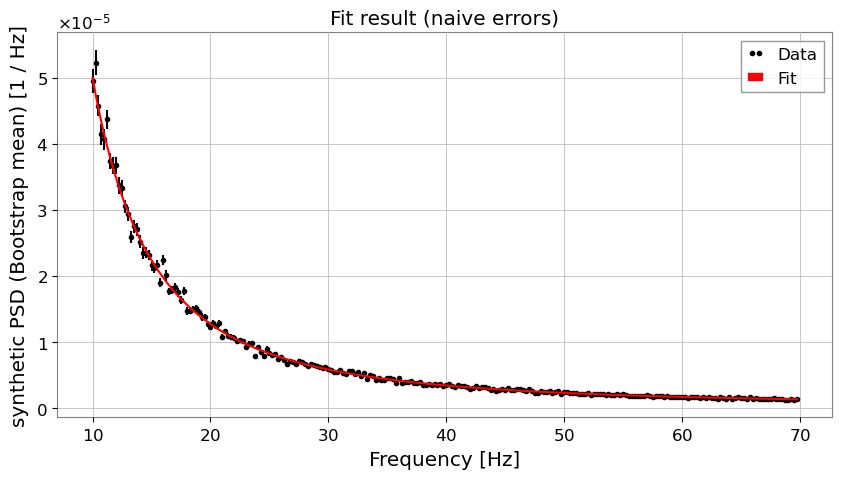

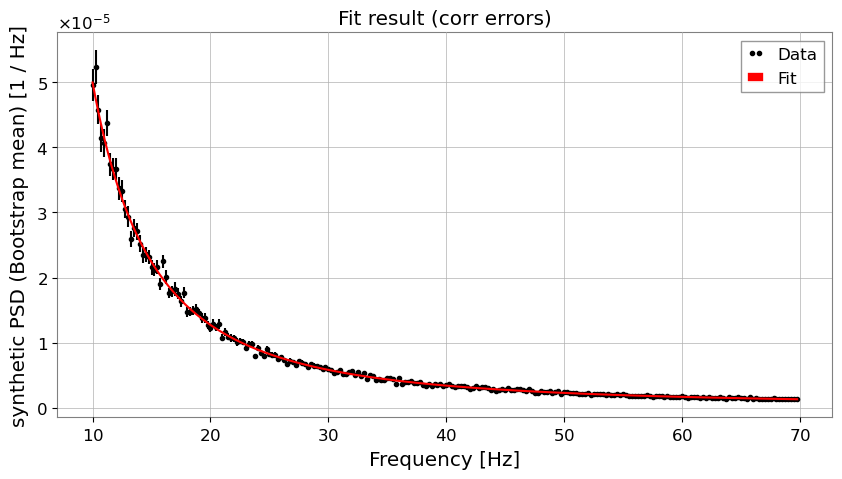

In [5]:
f = spec.frequencies.to_value(u.Hz)
y = psd_corr.value  # 中心値（naive と同一のはず）

sigma_naive = 0.5 * (psd_naive.error_low.value + psd_naive.error_high.value)
sigma_corr = 0.5 * (psd_corr.error_low.value + psd_corr.error_high.value)

# 初期値（雑でOK）: iminuit は dict で与える
p0 = {
    "A": float(np.median(y)),
    "alpha": 2.0,
    "C": float(np.min(y)),
}
limits = {
    "A": (0.0, None),
    "alpha": (0.0, 10.0),
    "C": (0.0, None),
}

# gwexpy の Series.fit() を使用
fit_naive = psd_corr.fit(psd_model, sigma=sigma_naive, p0=p0, limits=limits)
fit_corr = psd_corr.fit(psd_model, sigma=sigma_corr, p0=p0, limits=limits)

rch2_naive = fit_naive.reduced_chi2
rch2_corr = fit_corr.reduced_chi2

print("true params:", (A_true, alpha_true, C_true))
print("fit (naive):", fit_naive.params)
print("fit (corr) :", fit_corr.params)
print(f"reduced chi^2 (naive) = {rch2_naive:.3f}")
print(f"reduced chi^2 (corr)  = {rch2_corr:.3f}")
display(fit_naive)
display(fit_corr)

fit_naive.plot(); plt.title("Fit result (naive errors)")
fit_corr.plot(); plt.title("Fit result (corr errors)");

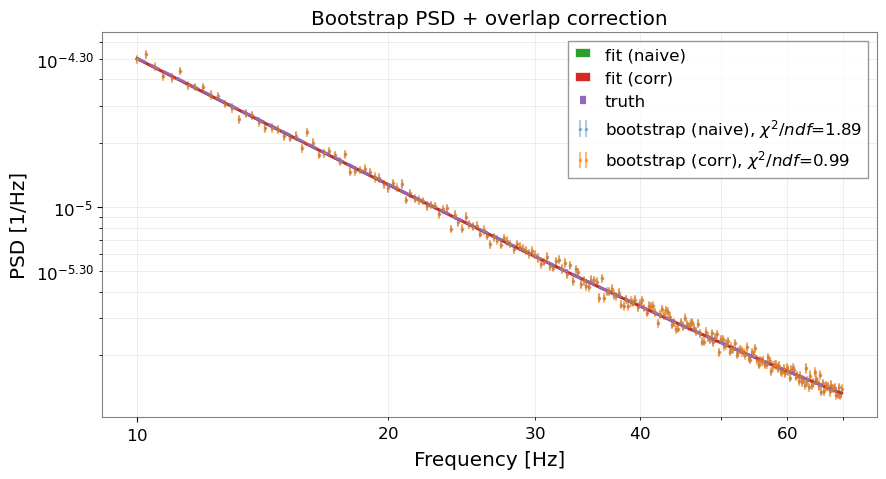

In [6]:
fig, ax = plt.subplots()

ax.errorbar(f, y, yerr=sigma_naive, fmt=".", ms=3, alpha=0.35, label=f"bootstrap (naive), $\\chi^2/ndf$={rch2_naive:.2f}")
ax.errorbar(f, y, yerr=sigma_corr, fmt=".", ms=3, alpha=0.55, label=f"bootstrap (corr), $\\chi^2/ndf$={rch2_corr:.2f}")

ax.plot(f, psd_model(f, **fit_naive.params), lw=2, label="fit (naive)")
ax.plot(f, psd_model(f, **fit_corr.params), lw=2, label="fit (corr)")
ax.plot(f, psd_true, lw=2, ls="--", label="truth")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("PSD [1/Hz]")
ax.set_title("Bootstrap PSD + overlap correction")
ax.grid(True, which="both", alpha=0.3)
ax.legend()

plt.show()
